# Classifying Tumors with Machine Learning

In [1]:
import numpy as np 
from numpy.random import Generator, PCG64

import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, confusion_matrix, ConfusionMatrixDisplay,
        accuracy_score, precision_score, recall_score, precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
# function for evaluation metrics
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='weighted')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

## Data

Each observation in this dataset contains lab test results about a tumor sample, such as clump or shapes. The target variable is the Class column. which is whether the tumor is malicious (cancer) or benign.

In [3]:
data_path = os.path.join('data', 'tumor.csv')
tumor_df = pd.read_csv(data_path)
tumor_df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [4]:
# input features and target variable
X = tumor_df.iloc[:, :-1]
feature_names = X.columns.values
y = tumor_df.Class

statistics summary of features in `X`:

In [5]:
X.describe()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Since all features are numeric and ranged between 1 to 10, we do not need to scale the feature values as they are already in the same range.

In [6]:
# class distribution of output y
y.value_counts(normalize=True)

Class
0    0.650073
1    0.349927
Name: proportion, dtype: float64

Since there is a small imbalance in the value of the target variable, we should stratify the data when splitting into training and testing sets.

In [7]:
# Split 80% as training dataset and 20% as testing dataset
rseed = 33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rseed)
print(pd.DataFrame(y_train).value_counts())
print(pd.DataFrame(y_test).value_counts())

Class
0        355
1        191
Name: count, dtype: int64
Class
0        89
1        48
Name: count, dtype: int64


## Logistic Regression

In [10]:
# Define a logistic regression model
LR_l2 = LogisticRegression(random_state=rseed, 
                           penalty='l2', # L2 penalty to shrink coefficients without removing any features from the model
                           solver='lbfgs', 
                           max_iter=1000, verbose=True)
# fit model
LR_l2.fit(X_train, y_train)

# prediction
y_pred_l2 = LR_l2.predict(X_test)
y_pred_l2

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0])

In [11]:
# evaluation metrics
evaluate_metrics(y_test, y_pred_l2)

{'accuracy': 0.9708029197080292,
 'recall': 0.9708029197080292,
 'precision': 0.9715110328047656,
 'f1score': 0.9709349565971047}

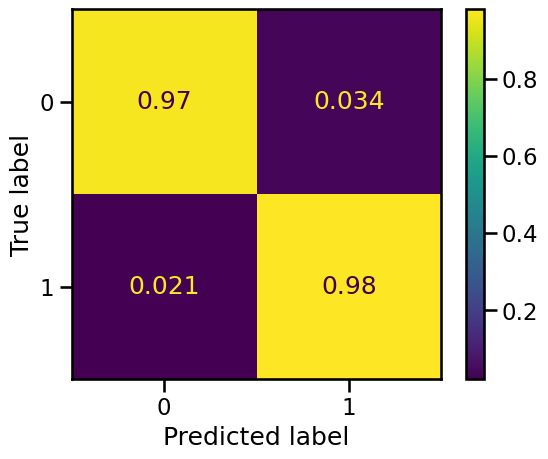

In [12]:
# confusion matrix
cf = confusion_matrix(y_test, y_pred_l2, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=LR_l2.classes_)
disp.plot()
plt.show()

For this dataset, recall is the more important metric, since it is important to correctly identify a malignant tumor. The recall score with logisitic regression is 96.6%, which is quite good.

## K-nearest neighbor

In [14]:
# Define a KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
# fit model
knn_model.fit(X_train, y_train)

# prediction
y_pred = knn_model.predict(X_test)

# evaluation metrics
evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9781021897810219,
 'recall': 0.9781021897810219,
 'precision': 0.9783171729209268,
 'f1score': 0.9781532068704714}

In [15]:
# Try K from 1 to 20
max_k = 20
# Create an empty list to store f1score for each k
recall_scores = []

for k in range(1, max_k + 1):
    # Create a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the classifier
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # Evaluate the classifier with f1score
    recall = recall_score(y_test, y_pred, average='weighted')
    recall_scores.append((k, round(recall, 4)))
# Convert the f1score list to a dataframe
recall_results = pd.DataFrame(recall_scores, columns=['K', 'Recall Score'])
recall_results = recall_results.set_index('K')
recall_results

,Recall Score
K,
1,0.9416
2,0.9416
3,0.9635
4,0.9635
5,0.9708
6,0.9781
7,0.9708
8,0.9781
9,0.9708


Text(0.5, 1.0, 'KNN Recall Score')

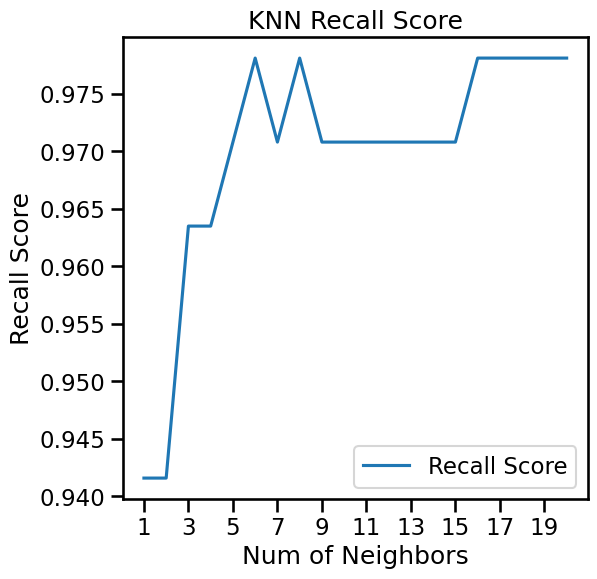

In [16]:
# Plot recall results
ax = recall_results.plot(figsize=(6, 6))
ax.set(xlabel='Num of Neighbors', ylabel='Recall Score')
ax.set_xticks(range(1, max_k, 2));

plt.title('KNN Recall Score')

KNN with k=6 leads to higher accuracy than logistic regression with recall score of 0.978.

## Decision Tree

In [17]:
# use grid search to choose the model hyperparameters
params_grid = {
    'criterion': ['gini', 'entropy'], # criterion used when splitting tree node
    'max_depth': [3, 5, 8, 10, 20],
    'min_samples_leaf': [1, 2, 3, 5, 8]
}

DTC = DecisionTreeClassifier(random_state=rseed)

grid_search = GridSearchCV(estimator = DTC, 
                        param_grid = params_grid, 
                        scoring='recall',
                        cv = 5, verbose = 1)

grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3}

In [18]:
# function to plot decision tree
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20)) 
    tree.plot_tree(model, 
                feature_names=feature_names,  
                filled=True)
    plt.show()

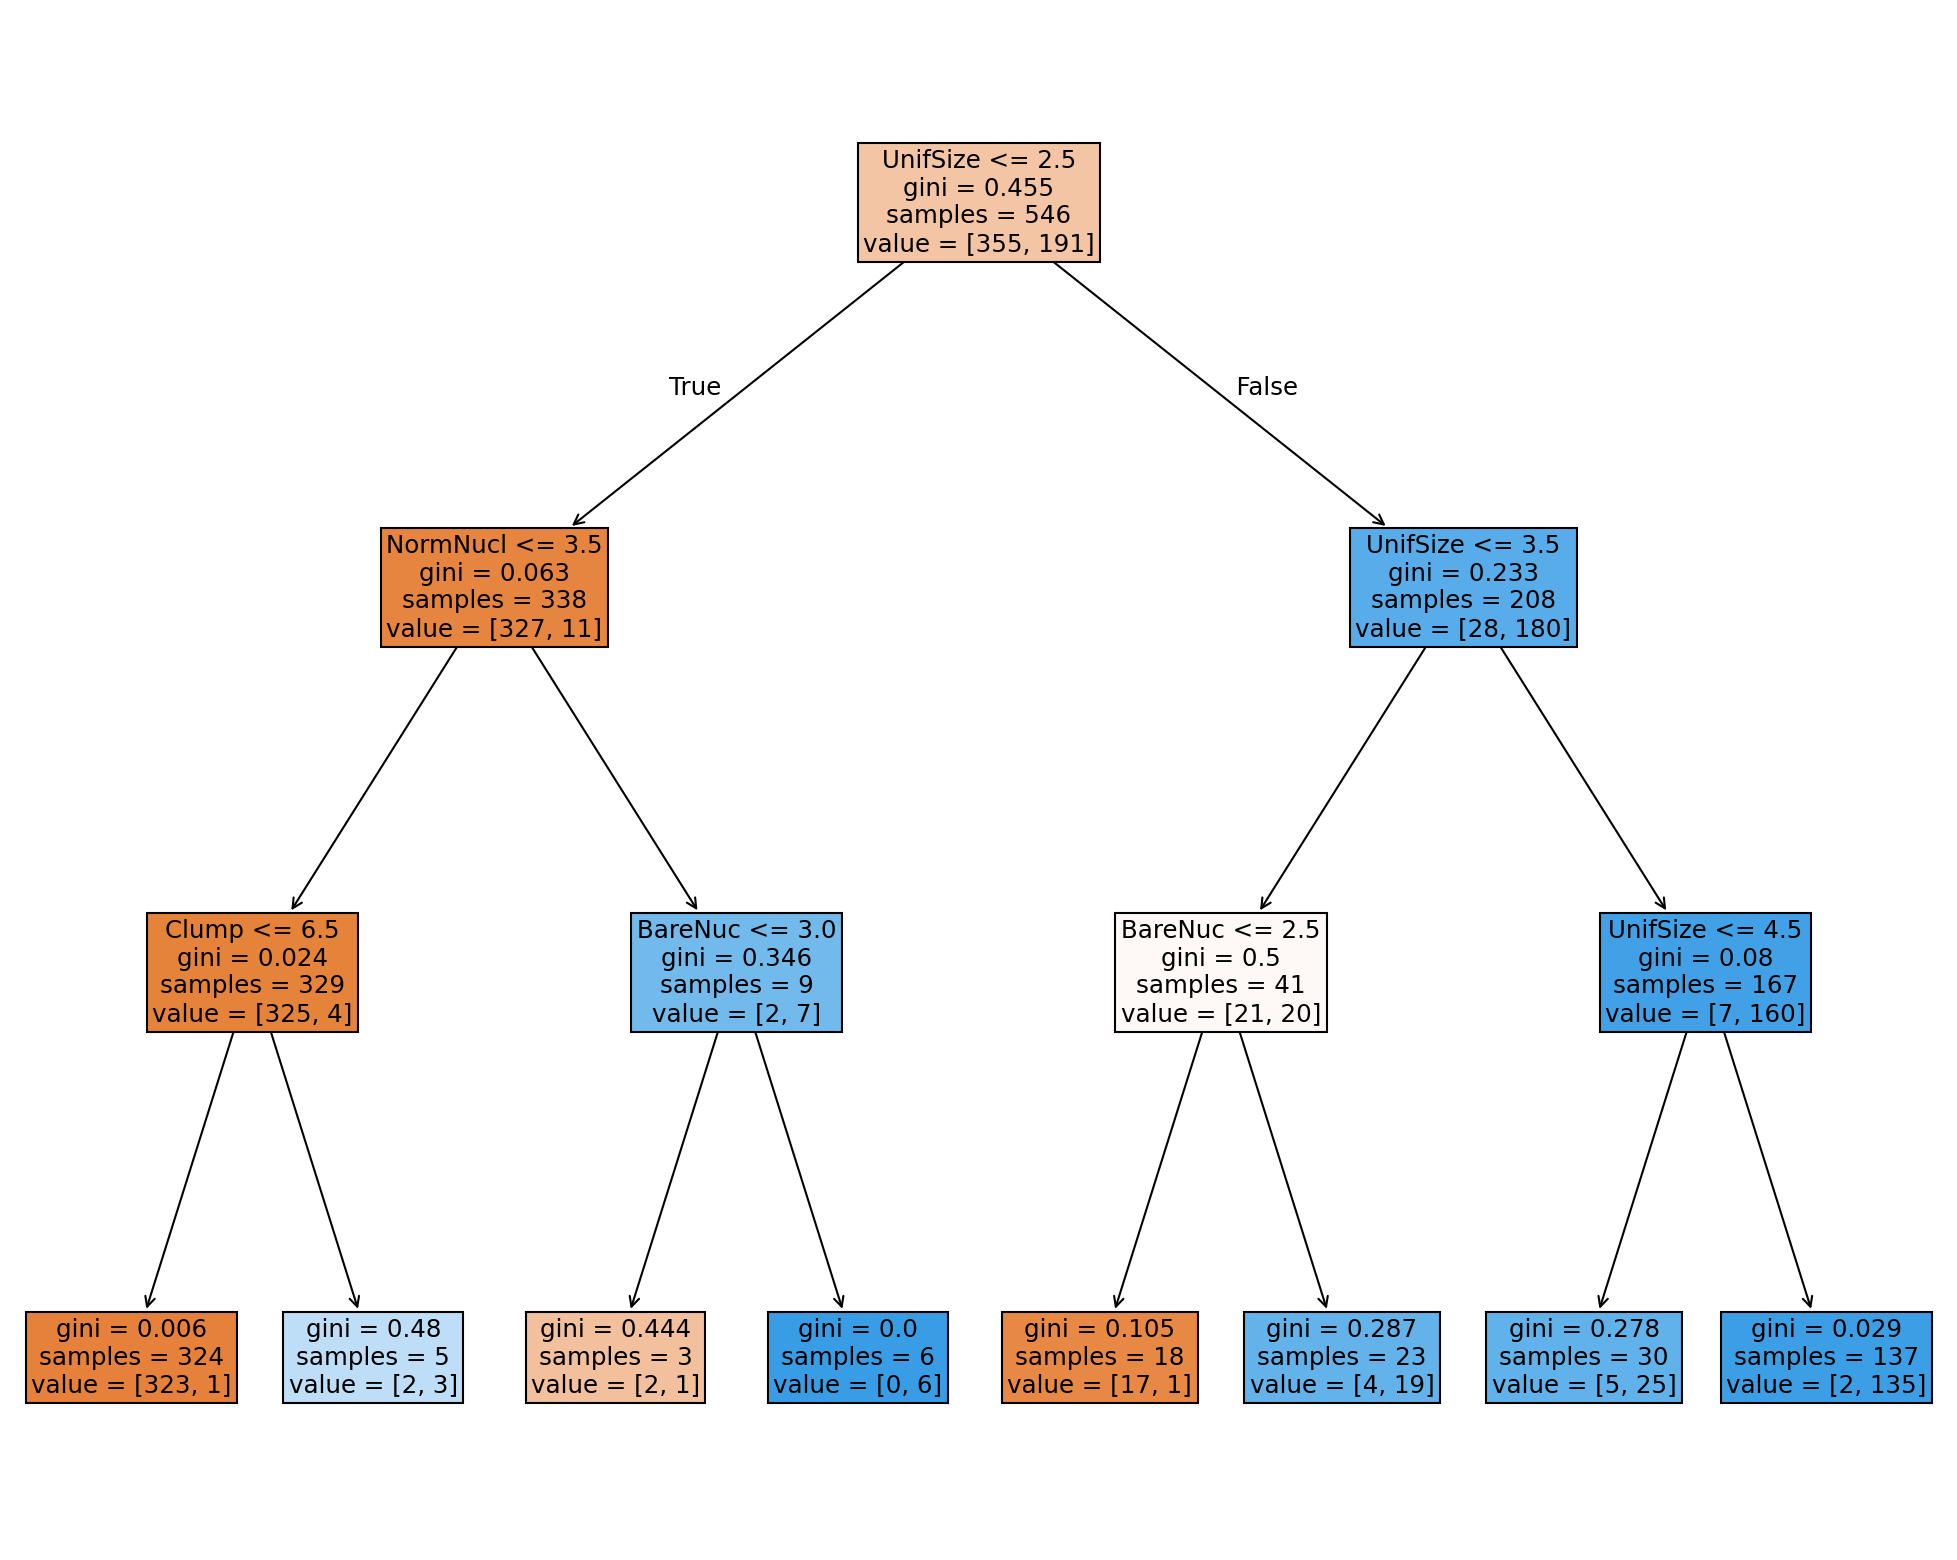

In [19]:
# plot tree with best params

DTC_best = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=3, random_state=rseed)
DTC_best.fit(X_train, y_train.values.ravel())
y_pred = DTC_best.predict(X_test)

# Plot the decision tree
plot_decision_tree(DTC_best, feature_names)

In [20]:
# scores for best model
evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9635036496350365,
 'recall': 0.9635036496350365,
 'precision': 0.9649664992461082,
 'f1score': 0.963743798780295}

The accuracy of the decision tree classifier is good, with recall score of 0.964, but the kNN classifier is still slightly better.

## Random Forest

In [21]:
# random forest classifier
RF = RandomForestClassifier(oob_score=True, 
                            random_state=rseed, 
                            warm_start=True,
                            n_jobs=-1)

In [22]:
# Iterate through the number of trees
oob_list = []
for n_trees in [20, 30, 40, 50, 100, 150, 200, 300, 400]:    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
20.0,0.034799
30.0,0.032967
40.0,0.032967
50.0,0.034799
100.0,0.031136
150.0,0.031136
200.0,0.031136
300.0,0.031136
400.0,0.031136


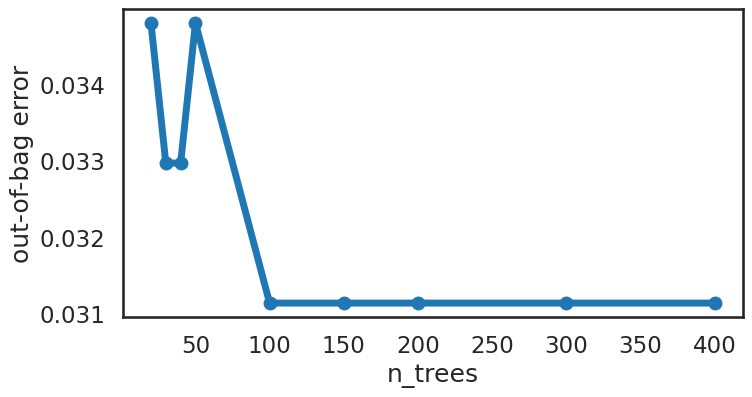

In [23]:
# plot out-of-bag error
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(8, 4), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [24]:
# scores for random forest classifier with 100 trees
RF = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=rseed, warm_start=True, n_jobs=-1)
# fit model
RF.fit(X_train, y_train)
# prediction
y_pred = RF.predict(X_test)
# metrics
evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9781021897810219,
 'recall': 0.9781021897810219,
 'precision': 0.9793902962644913,
 'f1score': 0.9782462792681772}

Recall is the same as kNN, but precision is slightly higher.

## Conclusions

Recall is one of the most important metrics for this medical dataset, to correctly identify a malignant tumors. The recall scores for the four models (logisitic regression, kNN, decision tree, random Forest) are (0.966, 0.978, 0.964, 0.978). All models are have good scores for recall (and also for other metrics), but the best are kNN and random Forest. Hence, for model interpretability, we recommend using kNN.

Possible next steps:

- Further tune the parameters of the random Forrest classifier to find better accuracy
- Since the dataset is small, we could try boosting methods, such as XGBoost, which are more computationally expensive. 